# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 20.09.2022

Мягкий дедлайн: 23:59MSK 04.10.2022

Жесткий дедлайн: 23:59MSK 10.10.2022

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [7]:
import torch
import wget
from torch import nn
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [5]:
%pip install wget

Note: you may need to restart the kernel to use updated packages.


In [9]:
wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip', 'data.txt.zip')

'data.txt.zip'

In [10]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [11]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [23]:
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor
from sklearn.metrics import root_mean_squared_error
import math

In [13]:
ridge = Ridge()
dummy = DummyRegressor()

ridge.fit(X_train, y_train)
dummy.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test).reshape(-1, 1)
y_pred_dummy = dummy.predict(X_test).reshape(-1, 1)
ridge_error = math.sqrt(mean_squared_error(y_test, y_pred_ridge))
constant_error = math.sqrt(mean_squared_error(y_test, y_pred_dummy))
print('Constant error:', constant_error)
print('Ridge error:', ridge_error)

Constant error: 10.85246390513634
Ridge error: 9.510160711373398


## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [14]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [15]:
from sklearn.preprocessing import normalize
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

In [16]:
b_size = 100
n_workers = 2
n_neurons = 100

In [17]:
scaler = StandardScaler().fit(y_train.reshape(-1, 1))
y_train_scaled = scaler.transform(y_train.reshape(-1, 1))

In [18]:
train_set = TensorDataset(torch.Tensor(normalize(X_train)), torch.Tensor(y_train_scaled))
train_loader = DataLoader(
    train_set, batch_size=b_size, shuffle=False, num_workers=n_workers
)
test_set = TensorDataset(torch.Tensor(normalize(X_test)), torch.Tensor(y_test))
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=b_size, shuffle=False, num_workers=n_workers
)

model = nn.Sequential(
    nn.Linear(X_train.shape[1], n_neurons),
    nn.BatchNorm1d(n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, n_neurons),
    nn.BatchNorm1d(n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.functional.mse_loss

In [25]:
def train(model, optimizer, criterion, train_loader, test_loader):
    '''
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    '''
    running_loss = 0
    loss_values = []
    for X_tr, y_tr in tqdm(train_loader):
        optimizer.zero_grad()
        y_pred = model(X_tr)
        loss = criterion(y_pred, y_tr)
        running_loss += loss.item() * X_tr.size(0)
        loss_values.append(loss.item() * X_tr.size(0))
        loss.backward()
        optimizer.step()
    clear_output()
    plt.plot(loss_values)
    plt.show()

def test(model, criterion, test_loader):
    '''
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    '''
    fin_preds = []
    total_loss  = 0
    model.eval()
    with torch.no_grad():
        for X_te, y_te in tqdm(test_loader):
            y_pred = model(X_te)
            fin_preds.extend(list(y_pred))
            loss = torch.sqrt(criterion(y_pred, torch.Tensor(scaler.transform(y_te.reshape(-1, 1)))))
            total_loss += loss.item() * y_train.std()
    predicts = torch.Tensor(fin_preds)
    print('RMSE =', root_mean_squared_error(y_test, scaler.inverse_transform(predicts.reshape(-1, 1)).squeeze()))
    return predicts

In [26]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

100%|██████████| 517/517 [00:03<00:00, 134.58it/s]

RMSE = 10.850380508867232


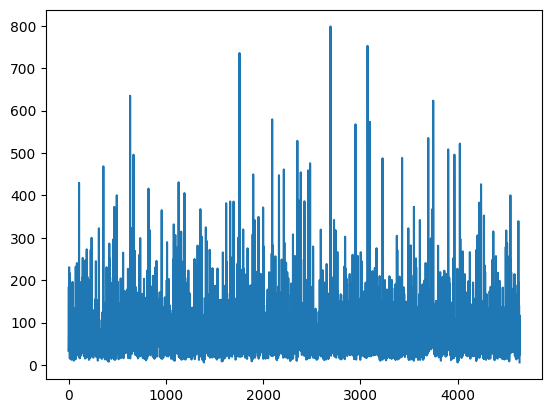

100%|██████████| 517/517 [00:03<00:00, 153.22it/s]

RMSE = 9.447392834158267


In [27]:
for epoch in range(1, 10):
    print('Epoch' + str(epoch))
    train(model, optimizer, criterion, train_loader, test_loader)
    test(model, criterion, test_loader)

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

Эксперименты:
1. Первый эксперимент был проведен с разными вариациями отимизации: были сравнены SGD (стохастический градиентный спуск), который выдавал значения 9+ при разных параметрах (при learning rate равному .001 RMSE = 9.626711141706592), и Adam, который давал лучшие результаты. В результате выбран **Adam**.
2. Второй эксперимент был связан с рамером батча. При уменьшении до 50 скорость увеличивалась, но значение RMSE = 9.274112574977524. При увеличении до 200 ошибка уменьшалась до 8.936572995271733, но увеличивалось время. В результате был выбран **batch_size = 100**.
3. Третий эксперимент про количество нейронов с полносвязном слое дал RMSE = 8.767482247509745 при 50 и 8.728591939457218 при 200 (но с большими потерями по времени). В результате было выбрано значение **100**, которое было оптимально по соотношению времени и качества.
4. Четвертый и последний эксперимент был связан с количеством процессов. Сравнивая num_workers = 1 (RMSE = 8.748865620495556) и равное 2, выбор был сделан в пользу последнего, так как при **num_workers = 2** ошибка уменьшилась до минимального 8.734015310336995.